In [97]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

import pickle
import joblib
from utils import predict_xr

In [98]:
%reload_ext autoreload
%autoreload 2

## Find and load S2 data

Load data and set up your array to use for prediction

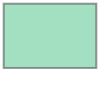

In [99]:
fiji_bbox = [177.347, -17.854, 177.591, -17.694]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry    

In [4]:
# Define collection
collection = "dep_s2_geomad"

# Define client (source)
client = Client.open("https://stac.staging.digitalearthpacific.org")

# Define items of collection
items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023",
).items())

print(f"Found {len(items)} items")

Found 2 items


In [5]:
# Define S2 Bands

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

# Define data variable

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y":2000, "time": np.atleast_1d(1),},
)

## Not sure whether to include the squeeze function 
# data = data.squeeze("time")

data
    

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    B8A          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B11          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    emad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bcmad        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    smad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

In [6]:
# S2 indices

# ndvi
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# mdnwi 
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# evi
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# savi
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# bsi
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# ndmi 
data["ndmi"] = (data["B08"] - data["B11"]) / (data["B08"] + data["B11"])

# ndbi
data["ndbi"] = (data["B06"] - data["B05"]) / (data["B06"] + data["B05"])

In [7]:
# Check resulting dataset with newly included total now adding up to 20 data variables
data

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/20)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

## Find and load SRTM elevation data

In [8]:
# Get MPC authorisation / dependencies

from planetary_computer import sign_url
import os

# URL for STAC API

# Define catalogue
catalogue_dem = "https://planetarycomputer.microsoft.com/api/stac/v1/"

# Define collection
collection_dem = "cop-dem-glo-30"

# Define client 
client_dem = Client.open(catalogue_dem)

# Define bbox
fiji_bbox = [177.347, -17.854, 177.591, -17.694]

# Define items / pystac_client list
items_dem = list(client_dem.search(collections=[collection_dem], bbox=fiji_bbox).items())
print(len(items_dem))

1


In [9]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [10]:
# Load dem data - 

# Loading dem data with args
data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

# Loading data without NaN / nodata values of -32768) 
data_dem = data_dem.where(data_dem != -32768)

# data_dem = data_dem.squeeze("time").rename({"data":"elevation"})

# Renaming but not squeezing for time yet - need to check whether this is needed at all for any of the datasets
data_dem = data_dem.rename({"data":"elevation"})

data_dem

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables:
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Merge S2 and srtm elevation

In [11]:
# After merging we should now have 21 data variables in the same order as the previous model / years. 
data_s2_dem = data.update(data_dem)
data_s2_dem

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/21)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Find and load S1 data

In [12]:
# Dependencies - already completed above
# Authorisation - already completed above

# Define S1 catalog and open
catalog_s1 = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog_s1)


In [13]:
# Define search parameters 
fiji_bbox = [177.347, -17.854, 177.591, -17.694]
datetime = "2023"

# Define pystac items list
items_s1 = list(client.search(collections=["dep_s1_mosaic"], bbox=fiji_bbox, datetime=datetime).items())
print(f"Found {len(items_s1)} items")


Found 2 items


In [14]:
# Data parameters

data_s1 = load(items_s1, bbox=fiji_bbox, resolution=10, chunks={"x":4000,"y":4000},)

data_s1 = data_s1.where(data_s1 != -32768)
               
data_s1

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    count        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    std_vh       (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    std_vv       (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    median_vh    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    median_vv    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

In [15]:
# Define bands / indices
data_s1["mean_vv_vh"] = (data_s1["mean_vv"]) / (data_s1["mean_vh"])

In [16]:
# Define mean s1
mean_s1 = data_s1.mean(dim="time")
mean_s1["mean_vv_vh"] = mean_s1.mean_vv/mean_s1.mean_vh

In [17]:
# load s1 data 

data_s1 = load(
    items_s1,
    bbox=fiji_bbox,
    resolution=10,
    bands=["mean_vv","mean_vh"],
    chunks={"x":4000,"y":4000},
)#.squeeze("time") # cCommented out squeeze time to avoid subsequent error when merging datasets: error msg "time is already a scalar variable"

# Mask nodata values
data_s1 = data_s1.where(data_s1 != -32768)

# mean_vv_vh
data_s1["mean_vv_vh"] = data_s1.mean_vv / data_s1.mean_vh

# check resulting s1 dataset
data_s1

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vv_vh   (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Merge all datasets together for ML xarray

In [18]:
merged = data_s2_dem.update(data_s1).compute()

In [19]:
# check resulting dataset which should have 24 data variables
merged

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/24)
    B02          (time, y, x) float32 1.406e+03 1.407e+03 ... 1.221e+03
    B03          (time, y, x) float32 1.257e+03 1.265e+03 ... 1.417e+03
    B04          (time, y, x) float32 1.125e+03 1.131e+03 ... 1.207e+03 1.2e+03
    B05          (time, y, x) float32 1.124e+03 1.131e+03 ... 1.756e+03
    B06          (time, y, x) float32 1.11e+03 1.113e+03 ... 3.254e+03 3.255e+03
    B07          (time, y, x) float32 1.117e+03 1.125e+03 ... 3.778e+03
    ...           ...
    ndmi         (time, y, x) float32 0.001364 -0.001361 ... 0.2399 0.2079
    ndbi         (time, y, x) float32 -0.006267 -0.008021 ... 0.2985 0.2991
    elevation    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    mean_vv      (time, y, x) float32 0.01451 0.01583 0.01457 ... 0.1974 0.1511
    mean_vh      (time, y, x) float32 0.004925 0.005292 ... 0.05143 0.03943
    mean_vv_vh   (time, y, x) float32 2.945 2.991 2.63 ... 3.843 3.838 3.834

## Run ML classifier

In [20]:
# Load in training data but do not use it to retrain model
training_file = "training_data/draft_inputs/MRD_dissagregated_24.geojson"

tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

## New code to clip tdata to bbox did not work
# tdata_clip = gpd.clip(tdata, fiji_bbox)

projected_training_data = tdata.to_crs("EPSG:3832")

# Remove the ID field
# projected_training_data.drop(columns=["id"], inplace=True)

In [85]:
from tqdm import tqdm

training_array = []


projected_training_data = tdata.to_crs("EPSG:3832")


def get_training_data(id_row):
    _, row = id_row
    cls_id = row["lulc_code"]
    # id = row["id"]
    geom = row["geometry"]

    # Get xarray values at the point
    x = merged.sel(x=geom.x, y=geom.y, method="nearest")
    one_point = [cls_id] + [float(v) for v in x.values()]
    return one_point


with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(
        tqdm(
            executor.map(get_training_data, projected_training_data.iterrows()),
            total=len(projected_training_data),
        )
    )

print(f"Fetched data for {len(training_array)} training points")

100%|██████████| 160/160 [00:00<00:00, 307838.83it/s]

Fetched data for 160 training points


In [87]:
classifer = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = "model_20240209_2.dump"
loaded_model = joblib.load("model_20240209_2.dump")

# filename = 'model_20240209.dump'
# joblib.dump(model, filename)
# model = "model_20240209.dump"
# loaded_model = pickle.load(open("model_20240209.dump", 'rb'))

# filename = "model_20240209.sav"
# model = "model_20240209.sav"
# loaded_model = pickle.load(open(filename, 'rb'))

In [88]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3832")

ll = [-17.854, 177.347]
ur = [-17.694, 177.591]

ll_projected = transformer.transform(*ll)
ur_projected = transformer.transform(*ur)


predict_subset = merged.sel(
    x=slice(ll_projected[0], ur_projected[0]), y=slice(ur_projected[1], ll_projected[1])
)
# This one loads all the data from all Viti Levu
predict_subset = predict_subset.fillna(-9999)
predict_subset

<xarray.Dataset>
Dimensions:      (time: 1, y: 1859, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/24)
    B02          (time, y, x) float32 1.406e+03 1.407e+03 ... 1.204e+03
    B03          (time, y, x) float32 1.257e+03 1.265e+03 ... 1.378e+03
    B04          (time, y, x) float32 1.125e+03 1.131e+03 ... 1.185e+03
    B05          (time, y, x) float32 1.124e+03 1.131e+03 ... 1.739e+03
    B06          (time, y, x) float32 1.11e+03 1.113e+03 ... 3.238e+03 3.236e+03
    B07          (time, y, x) float32 1.117e+03 1.125e+03 ... 3.76e+03 3.754e+03
    ...           ...
    ndmi         (time, y, x) float32 0.001364 -0.001361 ... 0.196 0.1656
    ndbi         (time, y, x) float32 -0.006267 -0.008021 ... 0.3001 0.3009
    elevation    (time, y, x) float32 -9.999e+03 -9.999e+03 ... -9.999e+03
    mean_vv      (time, y, x) float32 0.01451 0.01583 0.01457 ... 0.1854 0.1428
    mean_vh      (time, y, x) float32 0.004925 0.005292 ... 0.05114 0.04485
    mean_vv_vh   (time, y, x) float32 2.945 2.991 2.63 ... 4.039 3.625 3.184

In [89]:
# # This runs the actual prediction
# predicted = predict_xr(loaded_model, predict_subset, proba=True)

# # Convert to int
# cleaned_predictions = predicted.copy(deep=True)
# cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
# cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

# cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

In [90]:
merged = merged.fillna(-9999)

In [91]:
# To run this function:
# predicted = predict_xr(model, features, proba=True, persist=True, clean=True).compute()

# This runs the actual prediction
predicted = predict_xr(loaded_model, merged, proba=True)


# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

predicting...
   probabilities...


In [92]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 2717, y: 1860)
Coordinates:
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 7 7 7 7 7 7 7 7 7 7 7 7 ... 2 3 2 2 2 2 2 2 2 2 2 2
    prob         (y, x) float32 97.73 98.33 98.68 98.68 ... 54.52 54.42 48.41
Attributes:
    grid_mapping:  spatial_ref

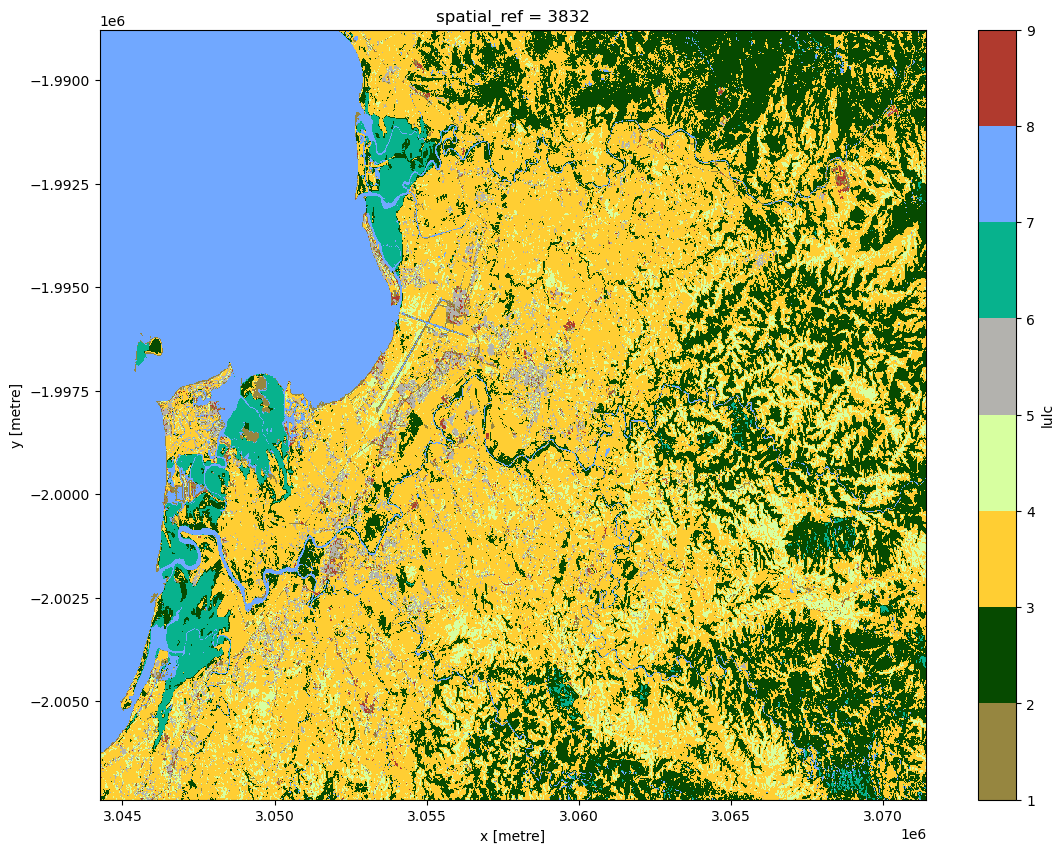

In [93]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#968640"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b3b2ae"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
    [8, "quarry", "#b03a2e"]
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [9]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

In [94]:
merged[["B04", "B03", "B02"]].to_array().plot.imshow(size=8, vmin=0, vmax=3000)

ValueError: DataArray must be 2d

In [83]:
cleaned_predictions.lulc.odc.explore(cmap=c_map)

AttributeError: 'ODCExtensionDa' object has no attribute 'explore'

In [95]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("lulc_nadi_2023_3.tif", overwrite=True)

PosixPath('lulc_nadi_2023_3.tif')